
# Chambolle-Pock 

This document is devoted to the resolution of discrete mean field games via Chambolle-Pock algorithm in the euclidean setting (see {cite}`chambolle2011first`).

## Packages

In [112]:
import numpy as np
from numpy import random
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

## Algorithms

__Chambolle-Pock__

The Chambolle Pock algorithm is a primal-dual method which aims at finding a saddle-point in optimization problems of the following form:

$$ \min_{x \in X} \max_{y \in Y} \langle K x, y \rangle + F(x) - G^\star(y)$$

for any $F$, $G$ l.s.c. convex and proper functions. In our case, we have the following saddle point problem:

$$\min_{(m_1,m_2,w,D) \in \mathcal{C}} \max_{(P,u,\gamma) \in \mathcal{K}} \langle \mathcal{A}(m_1,m_2,w,D),(P,u,\gamma) \rangle  + \mathcal{F}(m_1,m_2,w,D) - \mathcal{G}^\circ(P,u,\gamma)$$

Identifying the terms, the Chambolle Pock algorithm is given by :

* find 

$$(P^{n+1},u^{n+1},\gamma^{n+1}) = \text{prox}_{\sigma \mathcal{G}^\circ}((P^n,u^n,\gamma^n) + \sigma \mathcal{A}(\bar{m}_1^{n},\bar{m}_2^{n},\bar{w}^n,\bar{D}^n))$$

* find 

$$(m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) = \text{prox}_{\tau \mathcal{F}}((m_1^n,m_2^n,w^n,D^n) - \tau \mathcal{A}^\circ(P^{n+1},u^{n+1},\gamma^{n+1}))$$

* update 

$$(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1},\bar{D}^{n+1}) = (m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) + \theta((m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) - (m_1^{n},m_2^{n},w^{n},D^{n})) $$

## Data of the problem

In [113]:
def initial_mass(n):
    m_bar = np.zeros(n)
    for x in range(n):
        m_bar[x] = np.exp(-(x-n/2)**2/(n/4)**2)
    return(n*m_bar/np.sum(m_bar))


def displacement_cost(T,n):
    dx=1/n
    dt=1/T
    disp = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                disp[t,x,y] = ((y-x)*dx/dt)**2/4
    return(disp)

def penalisation_congestion(T,n):
    nu = np.zeros((T,n)) 
    for t in range(T):
        if t > T/4 and t < T/2:
            for x in range(n):
                if x > n/2:
                    nu[t,x] = 10
    return(nu)

def sharp_penalisation_congestion(T,n):
    eta = np.zeros((T,n)) + 3
    for t in range(T):
        for x in range(n):
            if (t > T/3 and t < 2*T/3) and (x > n/3 and x < 2*n/3):
                    eta[t,x] = 1/4
    return(eta)


def reference_demand(T):
    new_D_bar = np.zeros(T-1)
    for t in range(T-1):
        new_D_bar[t] = np.sin(t*(4*np.pi)/(T-1))
    return(new_D_bar)

def alpha_cost(T,n):
    dx=1/n
    dt=1/T
    disp = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                disp[t,x,y] = (y-x)*dx/dt
    return(disp)

## Computation of Chambolle-Pock steps

__Computation of__ $(P^{n+1},u^{n+1},\gamma^{n+1})$

* For any $(k_1,k_2,k_3) \in \mathcal{K}$ we have that

$$ \begin{align} \text{prox}_{\sigma \mathcal{G}^\circ}(k_1,k_2,k_3) & = \text{arg min}_{(P,u,\gamma) \in \mathcal{K}} \,\frac{1}{2} \|(P,u,\gamma) - (k_1,k_2,k_3)\|^2_{P,u,\gamma} - \sigma\langle u(0,\cdot),m_0(\cdot)\rangle, \\
& = (k_1, k_2 + \sigma m_0,k_3) \end{align}$$

* Then we have that

$$ \begin{align}P^{n+1} & = P^n + \sigma (A \bar{w}^{n} \Delta_x-\bar{D}^n)\\
u^{n+1} & = u^{n} + \sigma(S\bar{w}^{n}/\Delta_t - (I_0 + I/\Delta_t + I_T/\Delta_t)\bar{m}_1^{n} + \bar{m}_0) \\
\gamma^{n+1} & = \gamma^{n} + \sigma( \bar{m}_1^{n}-\bar{m}_2^{n})
\end{align}$$


__Computation of__ $P^{n+1}$

In [114]:
def prox_P(P,D,w,T,n,sigma,alpha):
    dx=1/n
    return(P + sigma*(np.sum(alpha*w*dx)-D))

__Computation of__ $u^{n+1}$

In [115]:
def prox_u(u,m_1,w,m_0,sigma,T,n):
    dt=1/T
    new_u = np.zeros((T,n))
    for t in range(T):
        if t==0:
            new_u[t] = u[t] + sigma*(m_0-m_1[t])
        else:
            for x in range(n):
                new_u[t,x] = u[t,x] + sigma*(np.sum(w[t-1,:,x]) - m_1[t,x])/dt
    return new_u

__Computation of__ $\gamma^{n+1}$

In [116]:
def prox_gamma(gamma,m_1,m_2,sigma):
    return(gamma + sigma*(m_1-m_2))

__Computation of__ $(m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1})$

The difficulty here comes from the domain of $\ell$. Thus we use the Moreau's identity. We set $c = (c_1,c_2,c_3,c_4) \in \mathcal{C}$,

$$\begin{align}
c_1 &= m_1^n - \tau( -(I_0/\Delta_t + I/\Delta_t + I_T)u^{n+1} + \gamma^{n+1}),\\
c_2 &=  m_2^n + \tau\gamma^{n+1},\\
c_3 &= w^n - \tau ( A^\star P^{n+1}  + S^\star u^{n+1}/\Delta_t),\\
c_4 &= D^n + \tau P^{n+1}.
\end{align}$$

Then we have 

$$(m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) = \text{prox}_{\tau \mathcal{F}}(c).$$

By the by the Moreau's identity we have that

$$(m_1^{n+1},w^{n+1})  = (c_1,c_3) - \tau(a_1,b),$$

where

$$\begin{align}
(a_1,b) & = \text{arg min}_{(a_1,b) \in \mathcal{C}} \frac{1}{2} (\| (a_1 - c_1)/\tau \|_m^2 + \| (b - c_3)/\tau \|_w^2) + \chi_Q(a_1,b) \\
& =  \Pi_Q(c_1/\tau,c_3/\tau).
\end{align} $$

For $t = T$ we have that

$$m_1^{n+1}(T) = m_1^n(T) - \tau (-u^{n+1} + \gamma^{n+1})(T).$$

* $(m_1^{n+1},w^{n+1})$ is given by

$$
(m_1^{n+1},w^{n+1})  = (c_1,c_3) - \tau \Pi_Q(c_1/\tau,c_3/\tau), \qquad m_1^{n+1}(T) = m_1^n(T) - \tau (-u^{n+1} + \gamma^{n+1})(T).$$

* $m_2^{n+1}$ is given by

$$ m_2^{n+1}  = \text{prox}_{\tau F}(c_2).$$

* $D^{n+1}$ is given by

$$ D^{n+1}  = \text{prox}_{\tau \phi}(c_4) = c_4 - \tau \text{prox}_{\phi^\star/\tau}(c_4/\tau).$$

__Computation of__ $D^{n+1}$

We have that

$$\begin{equation}
\text{prox}_{\xi \phi}(k_1) = \begin{cases} D_{max} & \text{ if }  \frac{k_1 - \tau D_0 \bar{D}}{1 + \tau D_0} > D_{max} \\
 D_{min} & \text{ if }  \frac{k_1 - \tau D_0 \bar{D}}{1 + \tau D_0} < D_{min} \\
 \frac{k_1 - \tau D_0 \bar{D}}{1 + \tau D_0} & \text{otherwise}
\end{cases} \end{equation}$$

In [117]:
def prox_phi_star_quad(X,Db,D_0,tau,T,n,D_min,D_max):
    argmin = (X - tau*D_0*Db)/(1 + tau*D_0)
    if argmin > D_max:
        argmin = D_max
    if argmin < D_min:
        argmin = D_min
    return(argmin)

def Local_D_prox_quad(D,P,T,n,tau,Db,D_0,D_min,D_max):
    c= D + tau*P
    new_Dt = prox_phi_star_quad(c,Db,D_0,tau,T,n,D_min,D_max)
    return(new_Dt)

def D_prox_quad(D,P,T,n,tau,alpha,Db,D_0,D_min,D_max):
    new_D = np.zeros(T-1)
    for t in range(T-1):
        new_D[t] = Local_D_prox_quad(D[t],P[t],T,n,tau,Db[t],D_0,D_min,D_max)
    return new_D

__Computation of__ $m_2^{n+1}$

In [118]:
def prox_coeff_F_sharp(X,nu,eta,coeff):
    argmin = (X - coeff*nu)/(coeff + 1)
    if argmin>eta:
        argmin = eta
    if argmin<0:
        argmin = 0
    return(argmin)

def m_2_prox(m_2,gamma,nu,eta,tau,T,n):
    m_2_new = np.zeros((T,n))
    c_2 = 0
    for t in range(T):
        for x in range(n):
            c_2 = m_2[t,x] + tau*gamma[t,x]
            m_2_new[t,x] = prox_coeff_F_sharp(c_2,nu[t,x],eta[t,x],tau)
    return(m_2_new)

__Computation of__ $(m_1^{n+1},w^{n+1})$

In [119]:
def proj_Q(a_bar,b_bar,beta,n):
    a = 0
    b = np.zeros(n)
    beta_bar = beta-b_bar
    beta_bar_sort = np.sort(beta_bar)
    k = 0
    sum_beta_bar_sort = 0
    derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    while (derivative_beta < 0) and (k < n-1):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = k+1
        derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    if (k==n-1) and (derivative_beta < 0):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = n
    a = (a_bar + sum_beta_bar_sort)/(k+1)
    for y in range(n):
        b[y] = np.min(np.array([b_bar[y],beta[y] - a]))
    return (a,b)

def m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta):
    dt = 1/T
    dx=1/n
    (new_m_1,new_w) = (np.zeros((T,n)),np.zeros((T-1,n,n)))
    for t in range(T-1):
        for x in range(n):
            c_1 = m_1[t,x] - tau*(-u[t,x]/dt + gamma[t,x])
            c_3 = w[t,x] - tau*(alpha[t,x]*P[t] + u[t+1]/dt)
            (a,b) = proj_Q(c_1/tau,c_3/tau,beta[t,x],n)
            new_m_1[t,x] = c_1 - tau*a
            new_w[t,x] = c_3 - tau*b
    new_m_1[T-1] = m_1[T-1] - tau*(-u[T-1] + gamma[T-1])
    return (new_m_1,new_w)

__Computation of__ $(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1})$

In [120]:
def relax(var_m_1,var_m_2,var_w,var_D,m_1,m_2,w,D,theta):
    m_1_bar = var_m_1 + theta*(var_m_1-m_1)
    m_2_bar = var_m_2 + theta*(var_m_2-m_2)
    w_bar = var_w + theta*(var_w-w)
    D_bar = var_D + theta*(var_D-D)
    return(m_1_bar,m_2_bar,w_bar,D_bar)

__Strategy__ $\pi = w/m$ __and average strategy__

In [121]:
def equilibrium_strategy(m,w,T,n,tol=1e-5):
    strat = np.zeros((T-1,n,n))
    for t in range(T-1):
        for x in range(n):
            if m[t,x] > tol:
                strat[t,x] = w[t,x]/m[t,x]
    return(strat)

def mean_field_strategy(pi,T,n):
    mfs = np.zeros((T-1,n))
    for t in range(T-1):
        for x in range(n):
            for y in range(n):
                mfs[t,x] += pi[t,x,y]*(y-x)
    return(mfs)

In [122]:
def ergodic(var_m_1,var_m_2,var_w,var_D,var_u,var_gamma,var_P,m_1,m_2,w,D,u,gamma,P,k):
    m_1_bar = var_m_1/(k+1) + k*m_1/(k+1)
    m_2_bar = var_m_2/(k+1) + k*m_2/(k+1)
    w_bar = var_w/(k+1) + k*w/(k+1)
    D_bar = var_D/(k+1) + k*D/(k+1) 
    u_bar = var_u/(k+1) + k*u/(k+1) 
    gamma_bar = var_gamma/(k+1) + k*gamma/(k+1)
    P_bar = var_P/(k+1) + k*P/(k+1)
    return(m_1_bar,m_2_bar,w_bar,D_bar,u_bar,gamma_bar,P_bar)

__Computation of__ $\|\mathcal{A}\|$

A key condition in the Chambolle-Pock algorithm is given by $ \sigma \tau L^2 < 1$ where $L = \|\mathcal{A}\|$. For any $(m_1,m_2,w,D) \in \hat{\mathcal{K}}$ we have that

$$ \begin{align} \|\mathcal{A}(m_1,m_2,w,D)\|_{P,u,\gamma,D}^2 & = \|Aw \Delta_x -D\|_{P}^2 + \|Sw/\Delta_t - m_1( I_0 + I/\Delta_t + I_T/\Delta_t)\|_{u}^2 + \|m_1-m_2\|_{\gamma}^2 \\
& \leq 2 \left( \|A\|^2 \|w \Delta_x\|_{P}^2 + \|D\|_D^2 + n \|w\|_{w}^2/\Delta_t^2  + \|( I_0 + I/\Delta_t + I_T/\Delta_t)m_1\|_{u}^2 + \|m_1\|_{\gamma}^2 + \|m_2\|_{\gamma}^2 \right)\\
& \leq 2 \left( \|A\|^2  \|w\|_{w}^2 + \|D\|_D^2 + \|w\|_{w}^2/\Delta_t^2 + \|I_0/\Delta_t + I/\Delta_t + I_T\|^2 \|m_1\|_{m}^2 +  \|m_1\|_{m}^2 + \|m_2\|_{m}^2 \right) ,
\end{align} $$

where

$$ \|A\|^2 \leq \max_{t\in \mathcal{T}} \sum_{x \in S} \sum_{y \in S} \alpha(t,x,y)^2, \qquad \|I_0/\Delta_t + I/\Delta_t + I_T\|^2 \leq 1/\Delta_t^2.$$

Thus

$$ \begin{align} \|\mathcal{A}(m_1,m_2,w,D)\|_{P,u,\gamma,D}^2 & \leq 2 \left( \|A\|^2 + n/\Delta_t^2) \|w\|_{w}^2 + \|D\|_D^2  + (1/\Delta_t^2 + 1) \|m_1\|_{m}^2 + \|m_2\|_{m}^2 \right)\\
& \leq 2 \max\{\|A\|^2 + n/\Delta_t^2, 1/\Delta_t^2 + 1)\} \|(m_1,m_2,w,D)\|_{m,m,w,D}^2  \\
& \leq 2 (\|A\|^2 + n/\Delta_t^2)\|(m_1,m_2,w,D)\|_{m,m,w,D}^2.\end{align}$$

Finally

$$ \|\mathcal{A}(m_1,m_2,w,D)\| \leq \sqrt{2(\|A\|^2 + n/\Delta_t^2)}. $$

In [123]:
def norm_A(alpha,n,T):
    dt=1/T
    dx = 1/n
    norm_alpha = 0
    for x in range(n):
        norm_alpha = norm_alpha + np.sum(alpha[0,x]**2)
    return(np.sqrt(2*(n/(dt**2) + norm_alpha)))

__Reconstruction of__ $(u,\pi[u])$

In [124]:
def d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-3,mfg=1):
    dt=1/T
    dx=1/n
    new_u = np.zeros((T,n))
    new_pi = np.zeros((T-1,n,n))
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    new_u[T-1] = f[T-1]
    for t in range(T-1):
        for x in range(n):
            cost = np.zeros(n)
            cost = beta[T-2-t,x]*dt + alpha[T-2-t,x]*P[T-2-t]*dt + new_u[T-1-t]
            argmin = np.argmin(cost)
            if m[T-2-t,x]*dx>tol: 
                new_pi[T-2-t,x] = w[T-2-t,x]/m[T-2-t,x]
            else:
                new_pi[T-2-t,x,argmin] = 1
            new_u[T-2-t,x] = cost[argmin] + f[T-2-t,x]*dt
    return(new_u,new_pi)

__Error function__

In [125]:
def verification(P,u,gamma,m,pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg = 1):
    cost = np.zeros((T-1,n))
    Delta_u = np.zeros((T,n))
    Delta_pi = np.zeros((T-1,n,n))
    Delta_m = np.zeros((T,n))
    Delta_gamma = np.zeros((T,n))
    Delta_P = np.zeros(T-1)
    demand = np.zeros((T-1,n,n))
    dt=1/T
    dx=1/n
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    Delta_m[0] = abs(m[0] - m_0)*dx
    for x in range(n):
        Delta_u[T-1,x] = abs(u[T-1,x] - f[T-1,x])*dx
    for t in range(T-1):
        for x in range(n):
            arg = beta[t,x]*dt + alpha[t,x]*P[t]*dt + u[t+1]
            demand[t,x] = pi[t,x]*m[t,x]*alpha[t,x]*dx
            cost[t,x] = np.sum(pi[t,x]*(beta[t,x]*dt + alpha[t,x]*P[t]*dt)) + f[t,x]*dt
            Delta_pi[t,x] = abs(np.sum(pi[t,x]*arg) - np.sort(arg)[0])*dx
            Delta_m[t+1,x] = abs(m[t+1,x] - np.sum(pi[t,:,x]*m[t]))*dx
            Delta_u[t,x] = abs(u[t,x] - cost[t,x] - np.sum(pi[t,x]*u[t+1]))*dx
            if gamma[t,x] < nu[t,x]:
                Delta_gamma[t,x] = abs(gamma[t,x])*dt*dx
            elif gamma[t,x] > eta[t,x] + nu[t,x]:
                Delta_gamma[t,x] = abs(gamma[t,x] - eta[t,x])*dt*dx
            else:
                Delta_gamma[t,x] = abs(gamma[t,x] - m[t,x] - nu[t,x])*dt*dx
        D = np.sum(demand[t])
        if P[t] > D_0*(Db[t]+Dmax):
            Delta_P[t] = abs(P[t]-D_0*(Db[t]+Dmax))*dt
        elif P[t] < D_0*(Db[t]+Dmin):
            Delta_P[t] = abs(P[t]-D_0*(Db[t]+Dmin))*dt
        else:
            Delta_P[t] = abs(P[t]- D_0*(Db[t]+D))*dt
    return (np.sum(Delta_u),np.sum(Delta_pi),np.sum(Delta_m),np.sum(Delta_P),np.sum(Delta_gamma))

### Local transition version

In [126]:
tran_0 = np.array([0,1])
tran_interm = np.array([-1,0,1])
tran_n = np.array([-1,0])

def tran(x,n):
    if x == 0:
        return(tran_0)
    if x == n-1:
        return(tran_n)
    else:
        return(tran_interm)

def norm_A(alpha,n,T):
    dt=1/T
    norm_alpha = 0
    cst = 0
    for x in range(n):
        Y = tran(x,n) + x
        norm_alpha = norm_alpha + np.sum(alpha[0,x,Y]**2)
        if len(Y)>cst:
            cst = len(Y)
    return(np.sqrt(2*(cst/(dt**2) + norm_alpha)))

def m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta):
    dt = 1/T
    dx=1/n
    (new_m_1,new_w) = (np.zeros((T,n)),np.zeros((T-1,n,n)))
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            c_1 = m_1[t,x] - tau*(-u[t,x]/dt + gamma[t,x])
            c_3 = w[t,x,Y] - tau*(alpha[t,x,Y]*P[t] + u[t+1,Y]/dt)
            (a,b) = proj_Q(c_1/tau,c_3/tau,beta[t,x,Y],n,Y)
            new_m_1[t,x] = c_1 - tau*a
            new_w[t,x,Y] = c_3 - tau*b
    new_m_1[T-1] = m_1[T-1] - tau*(-u[T-1] + gamma[T-1])
    return (new_m_1,new_w)

def proj_Q(a_bar,b_bar,beta,n,Y):
    lenY = len(Y)
    a = 0
    b = np.zeros(lenY)
    beta_bar = beta-b_bar
    beta_bar_sort = np.sort(beta_bar)
    k = 0
    sum_beta_bar_sort = 0
    derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    while (derivative_beta < 0) and (k < lenY-1):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = k+1
        derivative_beta = (k+1)*beta_bar_sort[k] - a_bar - sum_beta_bar_sort
    if (k==lenY-1) and (derivative_beta < 0):
        sum_beta_bar_sort = sum_beta_bar_sort + beta_bar_sort[k]
        k = lenY
    a = (a_bar + sum_beta_bar_sort)/(k+1)
    for y in range(lenY):
        b[y] = np.min(np.array([b_bar[y],beta[y] - a]))
    return (a,b)

def prox_P(P,D,w,T,n,sigma,alpha):
    dx=1/n
    new_P = np.zeros(T-1)
    for t in range(T-1):
        result = 0
        for x in range(n):
            Y = tran(x,n) + x
            result += np.sum(alpha[t,x,Y]*w[t,x,Y])
        new_P[t] = P[t] + sigma*(result*dx - D[t])
    return new_P

def prox_u(u,m_1,w,m_0,sigma,T,n):
    dt=1/T
    new_u = np.zeros((T,n))
    for t in range(T):
        if t==0:
            new_u[t] = u[t] + sigma*(m_0-m_1[t])
        else:
            for x in range(n):
                Y = tran(x,n) + x
                new_u[t,x] = u[t,x] + sigma*(np.sum(w[t-1,Y,x]) - m_1[t,x])/dt
    return new_u

def d_p_mapping(m,w,gamma,P,alpha,beta,T,n,tol = 1e-3,mfg=1):
    dt=1/T
    dx=1/n
    new_u = np.zeros((T,n))
    new_pi = np.zeros((T-1,n,n))
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    new_u[T-1] = f[T-1]
    for t in range(T-1):
        for x in range(n):
            cost = np.zeros(n)
            Y = tran(x,n) + x
            cost[Y] = beta[T-2-t,x,Y]*dt + alpha[T-2-t,x,Y]*P[T-2-t]*dt + new_u[T-1-t,Y]
            argmin = np.argmin(cost[Y])
            if m[T-2-t,x]*dx>tol: 
                new_pi[T-2-t,x,Y] = w[T-2-t,x,Y]/m[T-2-t,x]
            else:
                new_pi[T-2-t,x,Y[argmin]] = 1
            new_u[T-2-t,x] = cost[Y[argmin]] + f[T-2-t,x]*dt
    return(new_u,new_pi)

def verification(P,u,gamma,m,pi,w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg = 1):
    cost = np.zeros((T-1,n))
    Delta_u = np.zeros((T,n))
    Delta_pi = np.zeros((T-1,n,n))
    Delta_m = np.zeros((T,n))
    Delta_gamma = np.zeros((T,n))
    Delta_P = np.zeros(T-1)
    demand = np.zeros((T-1,n,n))
    dt=1/T
    dx=1/n
    f = np.zeros((T,n))
    if mfg == 1:
        f = gamma
    Delta_m[0] = abs(m[0] - m_0)*dx
    for x in range(n):
        Delta_u[T-1,x] = abs(u[T-1,x] - f[T-1,x])*dx
    for t in range(T-1):
        for x in range(n):
            Y = tran(x,n) + x
            arg = beta[t,x,Y]*dt + alpha[t,x,Y]*P[t]*dt + u[t+1,Y]
            demand[t,x,Y] = pi[t,x,Y]*m[t,x]*alpha[t,x,Y]*dx
            cost[t,x] = np.sum(pi[t,x,Y]*(beta[t,x,Y]*dt + alpha[t,x,Y]*P[t]*dt)) + f[t,x]*dt
            Delta_pi[t,x] = abs(np.sum(pi[t,x,Y]*arg) - np.sort(arg)[0])*dx
            Delta_m[t+1,x] = abs(m[t+1,x] - np.sum(pi[t,Y,x]*m[t,Y]))*dx
            Delta_u[t,x] = abs(u[t,x] - cost[t,x] - np.sum(pi[t,x,Y]*u[t+1,Y]))*dx
            if gamma[t,x] < 0:
                Delta_gamma[t,x] = abs(m[t,x])*dt*dx
            elif gamma[t,x] > eta[t,x] + nu[t,x]:
                Delta_gamma[t,x] = abs(m[t,x] - eta[t,x])*dt*dx
            else:
                Delta_gamma[t,x] = abs(gamma[t,x] - m[t,x])*dt*dx
        D = np.sum(demand[t])
        if P[t] > D_0*(Db[t]+Dmax):
            Delta_P[t] = abs(D-Dmax)*dt
        elif P[t] < D_0*(Db[t]+Dmin):
            Delta_P[t] = abs(D-Dmin)*dt
        else:
            Delta_P[t] = abs(D- (P[t]/D_0 - Db[t]))*dt
    return (np.sum(Delta_u),np.sum(Delta_pi),np.sum(Delta_m),np.sum(Delta_P),np.sum(Delta_gamma))

## Classical Chambolle-Pock

### MFG

In [127]:
T = 50
n = 50
alpha = np.zeros((T-1,n,n))


L = norm_A(alpha,n,T)+1
sigma = 1/(L) 
tau = 1/(L)
theta = 1
Dmin = -10
Dmax = 10

beta = displacement_cost(T,n)
#nu = penalisation_congestion(T,n)
nu = np.zeros((T,n))
eta = sharp_penalisation_congestion(T,n)


m_0 = initial_mass(n)
var_m_1 = np.zeros((T,n)) + 1
var_m_2 = var_m_1
var_w = np.zeros((T-1,n,n)) + 1 

D_0 = 1
Db = np.zeros(T-1)

P = np.zeros(T-1)
D = np.zeros(T-1)
u = np.zeros((T,n)) + 1
gamma = np.random.rand(T,n)
var_D = D
(m_1_bar,m_2_bar,w_bar,D_bar) = (var_m_1,var_m_2,var_w,var_D)

(av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = (m_1_bar,m_2_bar,w_bar,D_bar,u,gamma,P)

N = 10000
start = time.time()
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()
for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    #P = prox_P(P,D_bar,w_bar,n,alpha)
    u = prox_u(u,m_1_bar,w_bar,m_0,sigma,T,n)
    gamma = prox_gamma(gamma,m_1_bar,m_2_bar,sigma)
    (m_1,m_2,w,D) = (var_m_1,var_m_2,var_w,var_D)
    #var_D = D_prox_quad(D,P,T,n,tau,alpha,D_bar,D_0)
    var_m_2 = m_2_prox(m_2,gamma,nu,eta,tau,T,n)
    (var_m_1,var_w) = m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta)
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,m_1,m_2,w,D,theta)
    
    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(var_m_1,var_m_2,var_w,var_D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4547.07 s


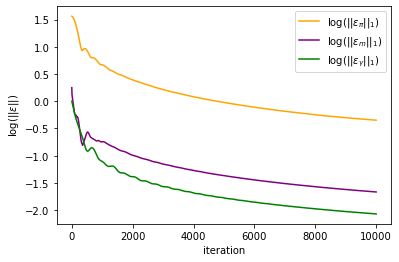

In [128]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
#plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||)$')
plt.legend()
plt.savefig('chambolle_pock_mfg_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

Text(0.5, 0, 'penalisation')

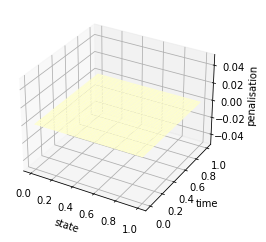

In [129]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = nu

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('penalisation')

Text(0.5, 0, 'sharp penalisation')

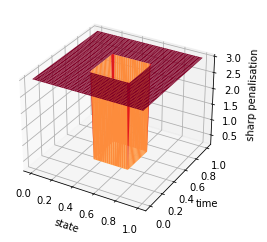

In [130]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = eta

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('sharp penalisation')

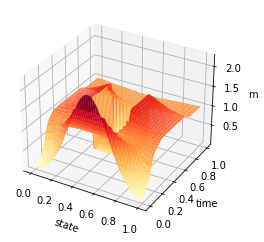

In [131]:
X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='YlOrRd')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('chambolle_pock_mfg_constraint_m.png',dpi=500, bbox_inches='tight')

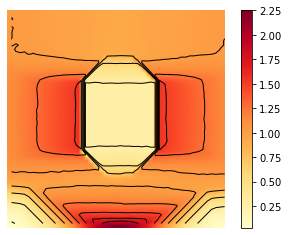

In [132]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_mfg_constraint_m_contour.png', dpi=500, bbox_inches='tight')

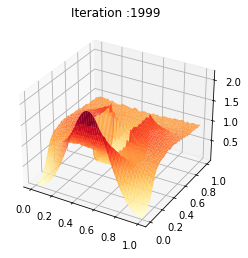

In [133]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfg_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

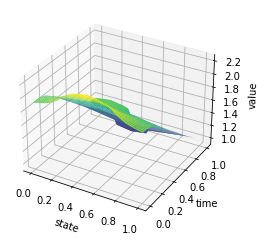

In [134]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('chambolle_pock_mfg_constraint_u.png',dpi=500, bbox_inches='tight')

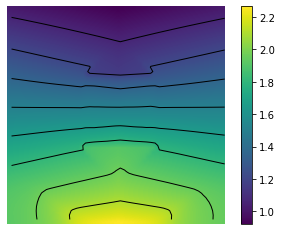

In [135]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(U)
maxu = np.max(U)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_mfg_constraint_u_contour.png',dpi=500, bbox_inches='tight')

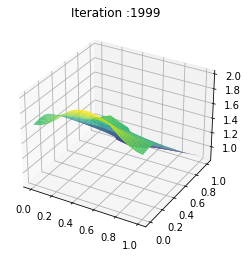

In [136]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfg_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

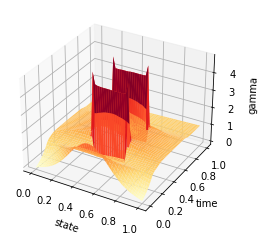

In [137]:
X, Y = np.meshgrid(y, t)

Z = av_gamma

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('gamma')

plt.savefig('chambolle_pock_mfg_constraint_gamma.png',dpi=500, bbox_inches='tight')

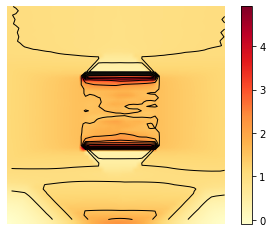

In [138]:
X, Y = np.meshgrid(t, y)

mingamma = np.min(Z)
maxgamma = np.max(Z)
levels = np.linspace(mingamma,maxgamma,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_constraint_mfg_gamma_contour.png', dpi=500, bbox_inches='tight')

__Equilibrium strategy__

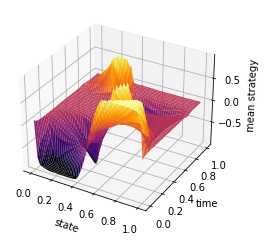

In [139]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('chambolle_pock_mfg_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

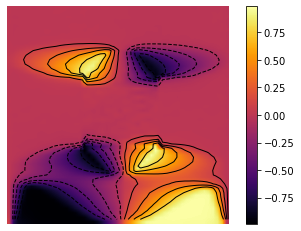

In [140]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_mfg_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

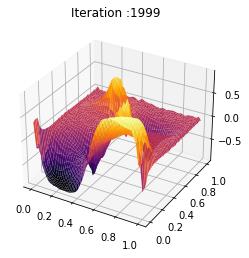

In [141]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfg_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

### MFGC

In [142]:
N = 10000
T = 50
n = 50

alpha = alpha_cost(T,n)


L = norm_A(alpha,n,T) + 1
sigma = 1/L
tau = 1/L
theta = 1
Dmin = -2
Dmax = 0

beta = displacement_cost(T,n)
nu = np.zeros((T,n))

D_0 = 1/2
Db = reference_demand(T)*2

m_0 = initial_mass(n)
var_m_1 = np.zeros((T,n)) + 1
var_m_2 = var_m_1
var_w = np.zeros((T-1,n,n)) + 1
var_D = Db

P = np.random.rand(T-1)
u = np.random.rand(T,n)
gamma = np.zeros((T,n))

(m_1_bar,m_2_bar,w_bar,D_bar) = (var_m_1,var_m_2,var_w,var_D)
(av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = (m_1_bar,m_2_bar,w_bar,D_bar,u,gamma,P)

mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()
for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    P = prox_P(P,D_bar,w_bar,T,n,sigma,alpha)
    u = prox_u(u,m_1_bar,w_bar,m_0,sigma,T,n)
    gamma = prox_gamma(gamma,m_1_bar,m_2_bar,sigma)
    (m_1,m_2,w,D) = (var_m_1,var_m_2,var_w,var_D)
    var_D = D_prox_quad(D,P,T,n,tau,alpha,Db,D_0,Dmin,Dmax)
    (var_m_1,var_w) = m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta)
    var_m_2 = m_2 + tau*gamma
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,m_1,m_2,w,D,theta)
    
    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(var_m_1,var_m_2,var_w,var_D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4,mfg=0)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg=0))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4572.4 s


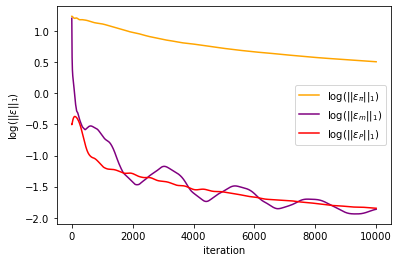

In [143]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
#plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||_1)$')
plt.legend()
plt.savefig('chambolle_pock_mfgc_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

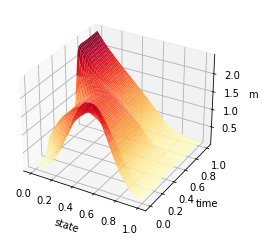

In [144]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('chambolle_pock_mfgc_constraint_m.png', dpi=500, bbox_inches='tight')

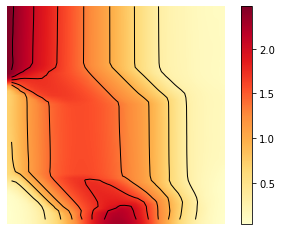

In [145]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)


plt.savefig('chambolle_pock_mfgc_constraint_m_contour.png', dpi=500, bbox_inches='tight')

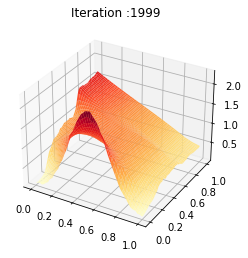

In [146]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfgc_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

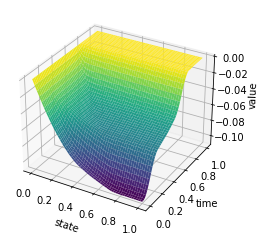

In [147]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('chambolle_pock_mfgc_constraint_u.png', dpi=500, bbox_inches='tight')

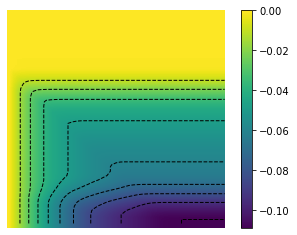

In [148]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(U)
maxu = np.max(U)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_mfgc_constraint_u_contour.png',dpi=500, bbox_inches='tight')

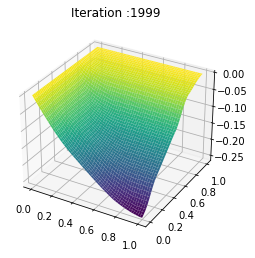

In [149]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfgc_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

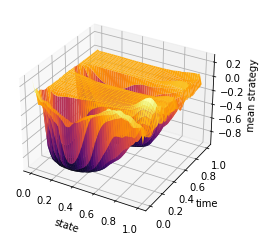

In [150]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('chambolle_pock_mfgc_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

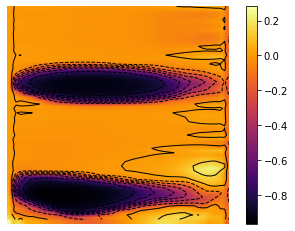

In [151]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('chambolle_pock_mfgc_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

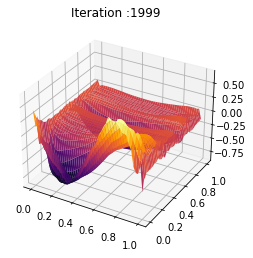

In [152]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('chambolle_pock_mfgc_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

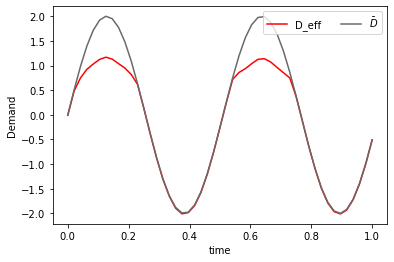

In [153]:
def real_demand(Db,D_0,alpha,w,T,n):
    dx = 1/n
    D_eff = np.zeros(T-1)
    for t in range(T-1):
        D_eff[t] = (np.sum(alpha[t]*w[t])*dx + Db[t])
    return(D_eff)

plt.plot(np.linspace(0,1,T-1),real_demand(Db,D_0,alpha,av_w,T,n), 'r-',label='D_eff')
plt.plot(np.linspace(0,1,T-1),Db,'dimgrey', label = r'$\bar{D}$')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Demand')

plt.savefig('chambolle_pock_mfgc_constraint_D.png', dpi=500, bbox_inches='tight')

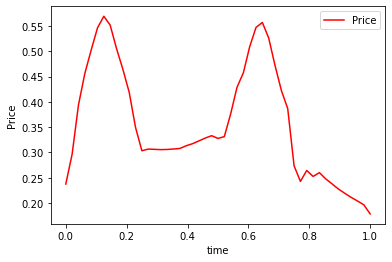

In [154]:
plt.plot(np.linspace(0,1,T-1),av_P, 'r-',label='Price')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Price')

plt.savefig('chambolle_pock_mfgc_constraint_P.png', dpi=500, bbox_inches='tight')

##  Overrelaxed Chambolle-Pock

__Overrelaxed Chambolle-Pock__


* find 
$$\xi^{n+1} = \text{prox}_{\tau \mathcal{F}}((m_1^n,m_2^n,w^n) - \tau \mathcal{A}^\circ(P^{n},u^{n},\gamma^{n}))$$

* update 

$$(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1}) = \xi^{n+1} + (\xi^{n+1}- (m_1^{n},m_2^{n},w^{n})) $$


* find 

$$\eta^{n+1} = \text{prox}_{\sigma \mathcal{G}^\circ}((P^n,u^n,\gamma^n) + \sigma \mathcal{A}(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1}))$$

* update

$$(m_1^{n+1},m_2^{n+1},w^{n+1},P^{n+1},u^{n+1},\gamma^{n+1}) = (1-\rho_n)(m_1^{n},m_2^{n},w^{n},P^{n},u^{n},\gamma^{n}) + \rho_n (\xi^{n+1},\eta^{n+1})$$


In [155]:
def convex_comb(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho):
    m_1_next = (1-rho)*m_1 + rho*var_m_1
    m_2_next = (1-rho)*m_2 + rho*var_m_2
    w_next = (1-rho)*w + rho*var_w
    D_next = (1-rho)*D + rho*var_D
    P_next = (1-rho)*P + rho*var_P
    u_next = (1-rho)*u + rho*var_u
    gamma_next = (1-rho)*gamma + rho*var_gamma
    return(m_1_next,m_2_next,w_next,D_next,P_next,u_next,gamma_next)

### MFG

In [156]:
T = 50
n = 50

alpha = np.zeros((T-1,n,n))

Dmin = -10
Dmax = 10

L = norm_A(alpha,n,T) + 1
sigma = 1/L
tau = 1/L
theta = 1
rho = 3/2


beta = displacement_cost(T,n)
#nu = penalisation_congestion(T,n)
nu = np.zeros((T,n))
eta = sharp_penalisation_congestion(T,n)


D_0 = 1
Db = np.zeros(T-1)


m_0 = initial_mass(n)
m_1 = np.zeros((T,n)) 
m_2 = np.zeros((T,n)) 
w = np.zeros((T-1,n,n)) 
D = np.zeros(T-1)
var_D = D

P = np.zeros(T-1)
u = np.random.rand(T,n)
gamma = np.random.rand(T,n)

var_P = P

(av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = (m_1,m_2,w,D,u,gamma,P)


N = 10000
start = time.time()
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()
for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    var_m_2 = m_2_prox(m_2,gamma,nu,eta,tau,T,n)
    (var_m_1,var_w) = m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta)
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,m_1,m_2,w,D,theta)
    var_u = prox_u(u,m_1_bar,w_bar,m_0,sigma,T,n)
    var_gamma = prox_gamma(gamma,m_1_bar,m_2_bar,sigma)
    (m_1,m_2,w,D,P,u,gamma) = convex_comb(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho)

    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(m_1,m_2,w,D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4477.54 s


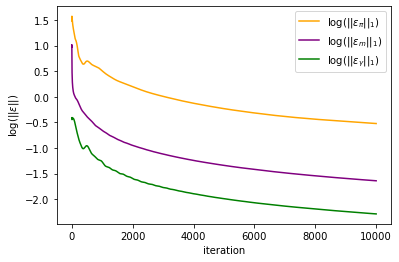

In [157]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
#plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||)$')
plt.legend()
plt.savefig('relaxed_chambolle_pock_mfg_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

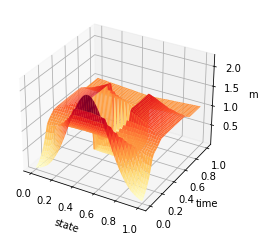

In [158]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='YlOrRd')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('relaxed_chambolle_pock_mfg_constraint_m.png',dpi=500, bbox_inches='tight')

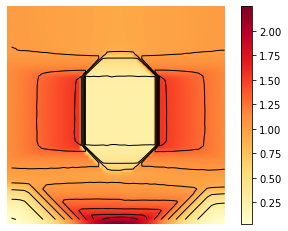

In [159]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('relaxed_chambolle_pock_mfg_constraint_m_contour.png', dpi=500, bbox_inches='tight')

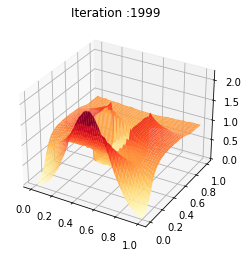

In [160]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfg_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

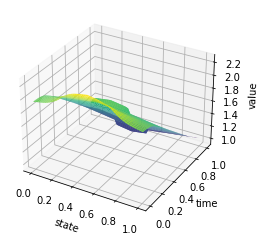

In [161]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('relaxed_chambolle_pock_mfg_constraint_u.png',dpi=500, bbox_inches='tight')

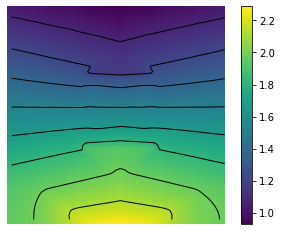

In [162]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('relaxed_chambolle_pock_mfg_constraint_u_contour.png',dpi=500, bbox_inches='tight')

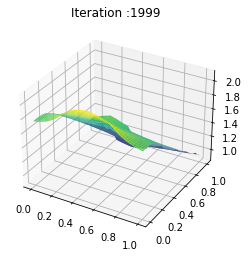

In [163]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfg_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

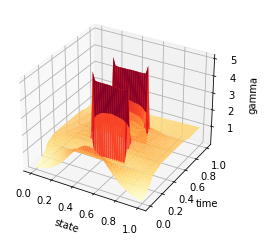

In [164]:
X, Y = np.meshgrid(y, t)

Z = av_gamma

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('gamma')

plt.savefig('relaxed_chambolle_pock_mfg_constraint_gamma.png',dpi=500, bbox_inches='tight')

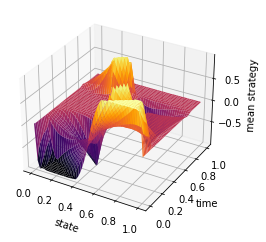

In [165]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('relaxed_chambolle_pock_mfg_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

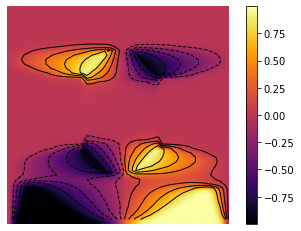

In [166]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('relaxed_chambolle_pock_mfg_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

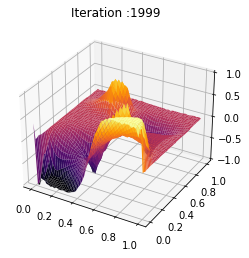

In [167]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfg_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

### MFGC

In [168]:
L = norm_A(alpha,n,T)
sigma = 1/L
tau = 1/L
theta = 1
Dmin = -2
Dmax = 0

beta = displacement_cost(T,n)

nu = np.zeros((T,n))
eta = np.zeros((T,n))

D_0 = 1/2
Db = reference_demand(T)*2
rho = 3/2

alpha = alpha_cost(T,n)

D_0 = 1/2
Db = reference_demand(T)*2

m_0 = initial_mass(n)
m_1 = np.zeros((T,n))
for t in range(T):
    m_1[t] = m_0
m_2 = m_1

w = np.zeros((T-1,n,n)) 
D = np.zeros(T-1)

P = np.zeros(T-1)
u = np.random.rand(T,n)
gamma = np.zeros((T,n))
var_gamma = gamma

(av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = (m_1_bar,m_2_bar,w_bar,D_bar,u,gamma,P)

N = 10000
start = time.time()
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()


for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    var_D = D_prox_quad(D,P,T,n,tau,alpha,Db,D_0,Dmin,Dmax)
    (var_m_1,var_w) = m_1_w_proj(P,gamma,u,m_1,w,T,n,tau,alpha,beta)
    var_m_2 = m_2 + tau*gamma
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,m_1,m_2,w,D,theta)
    var_P = prox_P(P,D_bar,w_bar,T,n,sigma,alpha)
    var_u = prox_u(u,m_1_bar,w_bar,m_0,sigma,T,n)
    var_gamma = prox_gamma(gamma,m_1_bar,m_2_bar,sigma)
    #(m_1,m_2,w,D) = (var_m_1,var_m_2,var_w,var_D)
    (m_1,m_2,w,D,P,u,gamma) = convex_comb(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho)
    
    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(var_m_1,var_m_2,var_w,var_D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4,mfg=0)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg=0))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()
print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4556.58 s


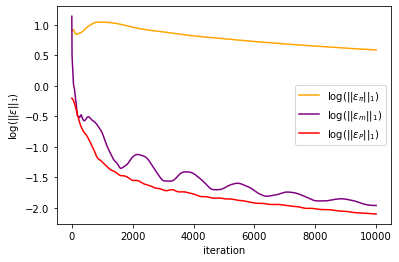

In [169]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
#plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||_1)$')
plt.legend()
plt.savefig('relaxed_chambolle_pock_mfgc_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

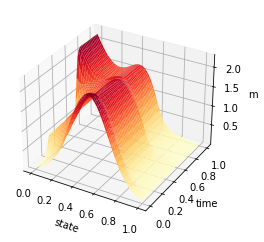

In [170]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_m.png', dpi=500, bbox_inches='tight')

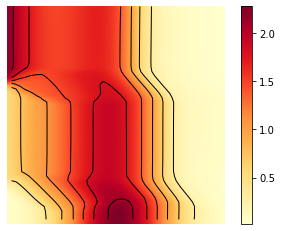

In [171]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)


plt.savefig('relaxed_chambolle_pock_mfgc_constraint_m_contour.png', dpi=500, bbox_inches='tight')

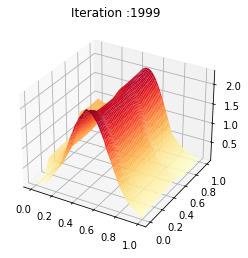

In [172]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfgc_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

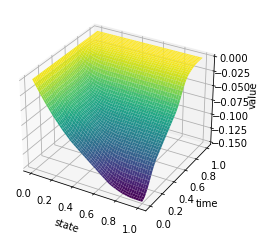

In [173]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_u.png', dpi=500, bbox_inches='tight')

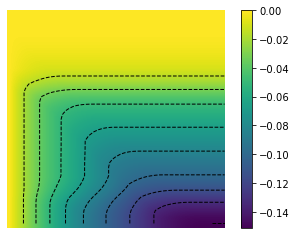

In [174]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_u_contour.png',dpi=500, bbox_inches='tight')

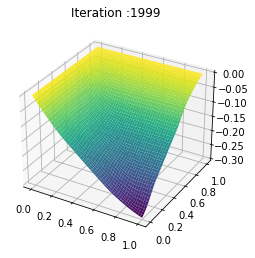

In [175]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfgc_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

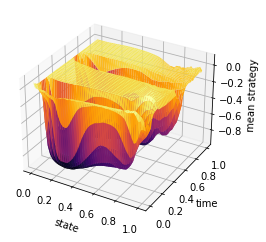

In [176]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

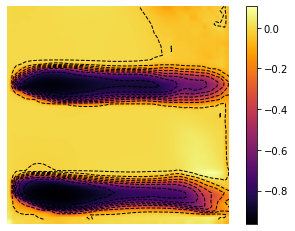

In [177]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

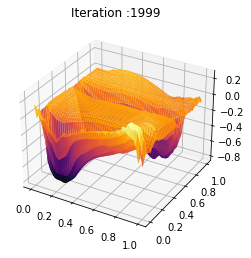

In [178]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('relaxed_chambolle_pock_mfgc_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

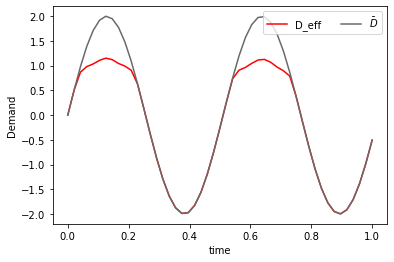

In [179]:
def real_demand(Db,D_0,alpha,w,T,n):
    dx = 1/n
    D_eff = np.zeros(T-1)
    for t in range(T-1):
        D_eff[t] = (np.sum(alpha[t]*w[t])*dx + Db[t])
    return(D_eff)

plt.plot(np.linspace(0,1,T-1),real_demand(Db,D_0,alpha,av_w,T,n), 'r-',label='D_eff')
plt.plot(np.linspace(0,1,T-1),Db,'dimgrey', label = r'$\bar{D}$')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Demand')

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_D.png', dpi=500, bbox_inches='tight')

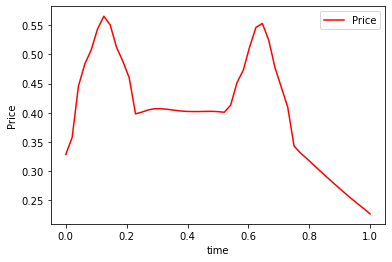

In [180]:
plt.plot(np.linspace(0,1,T-1),av_P, 'r-',label='Price')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Price')

plt.savefig('relaxed_chambolle_pock_mfgc_constraint_P.png', dpi=500, bbox_inches='tight')

## Inertial Chambolle-Pock

* update

$$ \begin{align}
\xi^n &= (m_1^{n},m_2^{n},w^{n},D^{n}) + \rho_n((m_1^{n},m_2^{n},w^{n},D^{n})-(m_1^{n-1},m_2^{n-1},w^{n-1},D^{n-1})) \\
\eta^n &= (P^{n},u^{n},\gamma^{n}) + \rho_n((P^{n},u^{n},\gamma^{n})-(P^{n-1},u^{n-1},\gamma^{n-1}))
\end{align}$$

* find 

$$(m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) = \text{prox}_{\tau \mathcal{F}}(\xi^n - \tau \mathcal{A}^\circ(\eta^n))$$

* update

$$(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1},\bar{D}^{n+1}) = (m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) + ((m_1^{n+1},m_2^{n+1},w^{n+1},D^{n+1}) - \xi^n) $$

* find 

$$(P^{n+1},u^{n+1},\gamma^{n+1}) = \text{prox}_{\sigma \mathcal{G}^\circ}(\eta^n + \sigma \mathcal{A}(\bar{m}_1^{n+1},\bar{m}_2^{n+1},\bar{w}^{n+1},\bar{D}^{n+1}))$$



In [181]:
def inertie(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho):
    m_1_next = var_m_1 + rho*(var_m_1 - m_1)
    m_2_next = var_m_2 + rho*(var_m_2 - m_2)
    w_next = var_w + rho*(var_w - w)
    D_next = var_D + rho*(var_D - D)
    P_next = var_P + rho*(var_P - P)
    u_next = var_u + rho*(var_u - u)
    gamma_next = var_gamma + rho*(var_gamma - gamma)
    return(m_1_next,m_2_next,w_next,D_next,P_next,u_next,gamma_next)

### MFG

In [182]:
T = 50
n = 50
alpha = np.zeros((T-1,n,n))


L = norm_A(alpha,n,T) + 1
sigma = 1/(L) 
tau = 1/(L)
theta = 1
rho = 1/3-1e-2

beta = displacement_cost(T,n)
#nu = penalisation_congestion(T,n)
nu = np.zeros((T,n))
eta = sharp_penalisation_congestion(T,n)
D_0 = 1
Db = np.zeros(T-1)

m_0 = initial_mass(n)
m_1 = np.zeros((T,n)) + 1
m_2 = np.zeros((T,n)) + 1
w = np.zeros((T-1,n,n)) + 1
D = np.zeros(T-1)
(var_m_1,var_m_2,var_w,var_D)=(m_1,m_2,w,D)


P = np.zeros(T-1)
u = np.random.rand(T,n)
gamma = np.random.rand(T,n)
(var_P,var_u,var_gamma)=(P,u,gamma)
var_P = P

(av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = (m_1,m_2,w,D,u,gamma,P)


N = 10000
start = time.time()
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()
for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    (zm_1,zm_2,zw,zD,zP,zu,zgamma) = inertie(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho)
    (m_1,m_2,w,D,P,u,gamma) = (var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma)
    #(zm_1,zm_2,zw,zP,zu,zgamma) = (var_m_1,var_m_2,var_w,var_P,var_u,var_gamma)
    var_m_2 = m_2_prox(zm_2,zgamma,nu,eta,tau,T,n)
    (var_m_1,var_w) = m_1_w_proj(zP,zgamma,zu,zm_1,zw,T,n,tau,alpha,beta)
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,zm_1,zm_2,zw,zD,theta)
    #var_P = P_prox_quad(P,w_bar,T,n,sigma,alpha,D_bar,D_0)
    var_u = prox_u(zu,m_1_bar,w_bar,m_0,sigma,T,n)
    var_gamma = prox_gamma(zgamma,m_1_bar,m_2_bar,sigma)
    
    
    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(m_1,m_2,w,D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()

print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4311.46 s


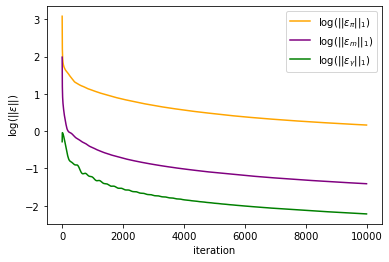

In [183]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
#plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||)$')
plt.legend()
plt.savefig('inertial_chambolle_pock_mfg_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

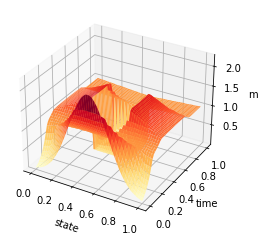

In [184]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='YlOrRd')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('inertial_chambolle_pock_mfg_constraint_m.png',dpi=500, bbox_inches='tight')

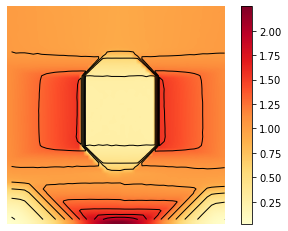

In [185]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('inertial_chambolle_pock_mfg_constraint_m_contour.png', dpi=500, bbox_inches='tight')

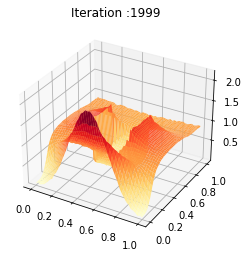

In [186]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfg_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

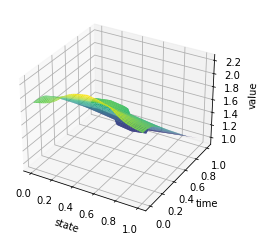

In [187]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('inertial_chambolle_pock_mfg_constraint_u.png',dpi=500, bbox_inches='tight')

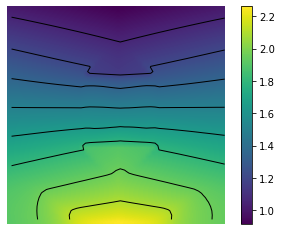

In [188]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('inertial_chambolle_pock_mfg_constraint_u_contour.png',dpi=500, bbox_inches='tight')

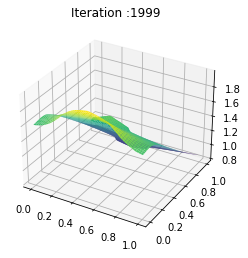

In [189]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfg_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

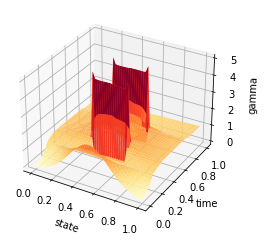

In [190]:
X, Y = np.meshgrid(y, t)

Z = av_gamma

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('gamma')

plt.savefig('inertial_chambolle_pock_mfg_constraint_gamma.png',dpi=500, bbox_inches='tight')

__Equilibrium strategy__

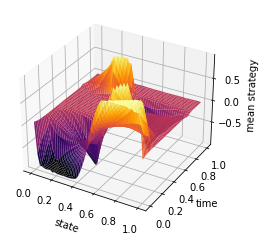

In [191]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('inertial_chambolle_pock_mfg_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

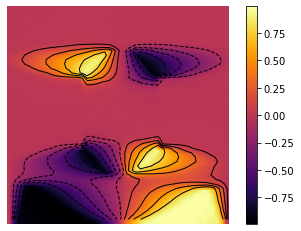

In [192]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('inertial_chambolle_pock_mfg_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

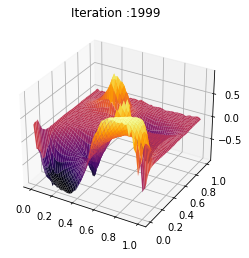

In [193]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfg_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

### MFGC

In [194]:
T = 50
n = 50

alpha = alpha_cost(T,n)

L = norm_A(alpha,n,T) + 1
sigma = 1/L
tau = 1/L
theta = 1
rho = 1/3-1e-2
Dmin = -2
Dmax = 0

beta = displacement_cost(T,n)
nu = np.zeros((T,n))

D_0 = 1/2
Db = reference_demand(T)*2

m_0 = initial_mass(n)
m_1 = np.zeros((T,n))
for t in range(T):
    m_1[t] = m_0
m_2 = m_1

w = np.zeros((T-1,n,n)) 
D = np.zeros(T-1)

P = np.zeros(T-1)
u = np.random.rand(T,n)
gamma = np.zeros((T,n))

(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma) = (m_1,m_2,w,D,P,u,gamma)


N = 10000
start = time.time()
mfg_error = np.zeros((N,5))
ev_m_s = np.zeros((N,T-1,n))
ev_m = np.zeros((N,T,n))
ev_u = np.zeros((N,T,n))

start = time.time()


for i in range(N):
    print(round(i/N*100, 2),"              \r",end = '')
    (zm_1,zm_2,zw,zD,zP,zu,zgamma) = inertie(var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma,m_1,m_2,w,D,P,u,gamma,rho)
    (m_1,m_2,w,D,P,u,gamma) = (var_m_1,var_m_2,var_w,var_D,var_P,var_u,var_gamma) 
    var_D = D_prox_quad(zD,zP,T,n,tau,alpha,Db,D_0,Dmin,Dmax)
    (var_m_1,var_w) = m_1_w_proj(zP,zgamma,zu,zm_1,w,T,n,tau,alpha,beta)
    #var_m_2 = zm_2 + tau*zgamma
    (m_1_bar,m_2_bar,w_bar,D_bar) = relax(var_m_1,var_m_2,var_w,var_D,zm_1,zm_2,zw,zD,theta)
    var_P = prox_P(zP,D_bar,w_bar,T,n,sigma,alpha)
    var_u = prox_u(zu,m_1_bar,w_bar,m_0,sigma,T,n)
    #var_gamma = prox_gamma(zgamma,m_1_bar,m_2_bar,sigma)
    
    (av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P) = ergodic(m_1,m_2,w,D,u,gamma,P,av_m_1,av_m_2,av_w,av_D,av_u,av_gamma,av_P,i)
    (U,Pi) = d_p_mapping(av_m_1,av_w,av_gamma,av_P,alpha,beta,T,n,tol = 1e-4,mfg=0)
    mfg_error[i] = np.array(verification(av_P,U,av_gamma,av_m_1,Pi,av_w,T,n,beta,nu,m_0,alpha,Db,Dmin,Dmax,eta,mfg=0))
    (ev_m_s[i],ev_m[i],ev_u[i]) = (mean_field_strategy(Pi,T,n),av_m_1,U)
    end = time.time()
print("\n execution time :",round(end-start,2), "s")

99.99               
 execution time : 4441.6 s


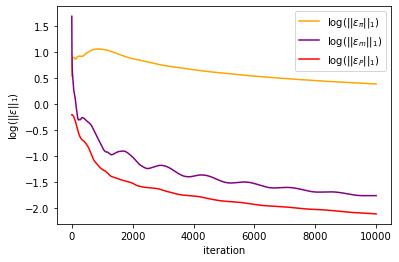

In [210]:
#plt.plot(np.log(mfg_error[:,0])/np.log(10), label = r'$\log(||\varepsilon_u||_1)$', color = 'blue')
plt.plot(np.log(mfg_error[:,1])/np.log(10), label = r'$\log(||\varepsilon_\pi||_1)$', color = 'orange')
plt.plot(np.log(mfg_error[:,2])/np.log(10), label = r'$\log(||\varepsilon_m||_1)$', color = 'purple')
#plt.plot(np.log(mfg_error[:,4])/np.log(10), label = r'$\log(||\varepsilon_{\gamma}||_1)$', color = 'green')
plt.plot(np.log(mfg_error[:,3])/np.log(10), label = r'$\log(||\varepsilon_P||_1)$', color = 'red')
plt.xlabel('iteration')
plt.ylabel(r'$\log(||\varepsilon||_1)$')
plt.legend()
plt.savefig('inertial_chambolle_pock_mfgc_constraint_error.png', dpi=500, bbox_inches='tight')
plt.show()

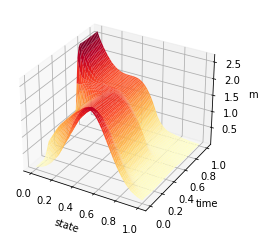

In [196]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, t)
Z = av_m_1

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='YlOrRd', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='v£iridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('m')

plt.savefig('inertial_chambolle_pock_mfgc_constraint_m.png', dpi=500, bbox_inches='tight')

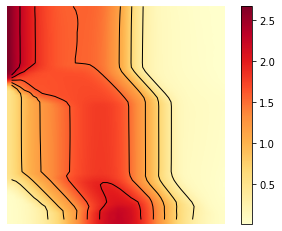

In [197]:
X, Y = np.meshgrid(t, y)
Z = av_m_1

minm = np.min(m_1_bar)
maxm = np.max(m_1_bar)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='YlOrRd')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)


plt.savefig('inertial_chambolle_pock_mfgc_constraint_m_contour.png', dpi=500, bbox_inches='tight')

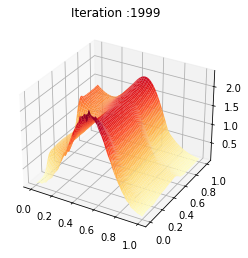

In [198]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="YlOrRd",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfgc_constraint_m_convergence.mp4',writer='ffmpeg',fps=fps)

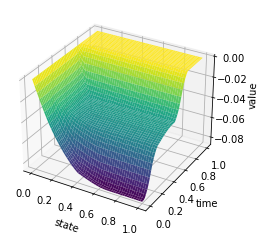

In [199]:
X, Y = np.meshgrid(y, t)
Z = U

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('value')

plt.savefig('inertial_chambolle_pock_mfgc_constraint_u.png', dpi=500, bbox_inches='tight')

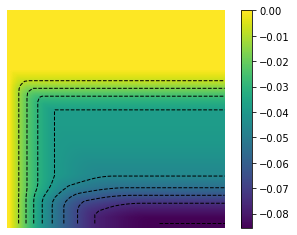

In [200]:
X, Y = np.meshgrid(t, y)
Z = U
minu = np.min(Z)
maxu = np.max(Z)
levels = np.linspace(minu,maxu,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='viridis')

plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('inertial_chambolle_pock_mfgc_constraint_u_contour.png',dpi=500, bbox_inches='tight')

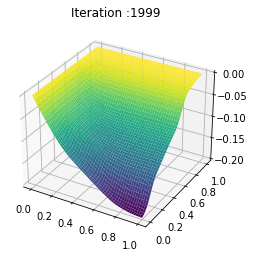

In [201]:
t = np.linspace(0, 1, T)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_u[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="viridis",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfgc_constraint_u_convergence.mp4',writer='ffmpeg',fps=fps)

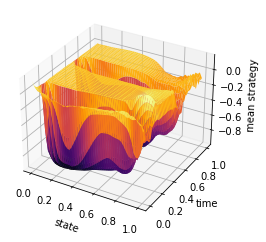

In [202]:
ti = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

X, Y = np.meshgrid(y, ti)
Z = mean_field_strategy(Pi,T,n)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='magma')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
#ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('state')
ax.set_ylabel('time')
ax.set_zlabel('mean strategy')

plt.savefig('inertial_chambolle_pock_mfgc_constraint_mean_strategy.png', dpi=500, bbox_inches='tight')

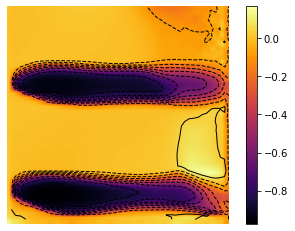

In [203]:
minm = np.min(Z)
maxm = np.max(Z)
levels = np.linspace(minm,maxm,10)

fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='bilinear', origin='lower',
                cmap='inferno')
plt.axis('off')
CS = ax.contour(Z,levels, origin='lower', colors='black',
                linewidths=1)
CBI = fig.colorbar(im)

plt.savefig('inertial_chambolle_pock_mfgc_constraint_mean_strategy_contour.png', dpi=500, bbox_inches='tight')

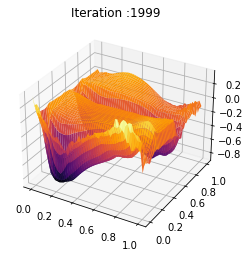

In [204]:
t = np.linspace(0, 1, T-1)
y = np.linspace(0, 1, n)

Nb_im = 2000
X, Y = np.meshgrid(y, t)
Z = ev_m_s[:Nb_im]

def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plt.title('Iteration :%s'%frame_number)
    plot[0] = ax.plot_surface(X, Y, Z[frame_number,:,:], cmap="inferno",edgecolor='none')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fps = 100
plot = [ax.plot_surface(X, Y, Z[0,:,:], rstride=1, cstride=1)]
ani = animation.FuncAnimation(fig, update_plot, Nb_im, fargs=(Z, plot), interval=2000/fps)

ani.save('inertial_chambolle_pock_mfgc_constraint_mean_strategy_convergence.mp4',writer='ffmpeg',fps=fps)

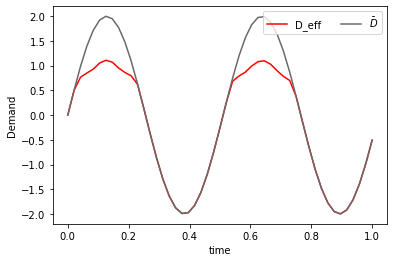

In [205]:
def real_demand(Db,D_0,alpha,w,T,n):
    dx = 1/n
    D_eff = np.zeros(T-1)
    for t in range(T-1):
        D_eff[t] = (np.sum(alpha[t]*w[t])*dx + Db[t])
    return(D_eff)

plt.plot(np.linspace(0,1,T-1),real_demand(Db,D_0,alpha,av_w,T,n), 'r-',label='D_eff')
plt.plot(np.linspace(0,1,T-1),Db,'dimgrey', label = r'$\bar{D}$')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Demand')

plt.savefig('inertial_chambolle_pock_mfgc_constraint_D.png', dpi=500, bbox_inches='tight')

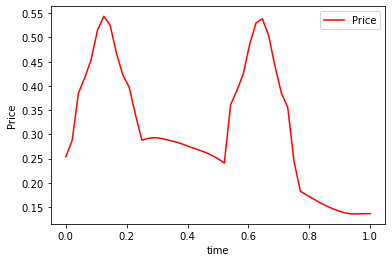

In [206]:
plt.plot(np.linspace(0,1,T-1),av_P, 'r-',label='Price')
plt.legend(loc='upper right',
           ncol=2)
plt.xlabel('time')
plt.ylabel('Price')

plt.savefig('inertial_chambolle_pock_mfgc_constraint_P.png', dpi=500, bbox_inches='tight')

```{bibliography} biblio.bib
:filter: docname in docnames
:style: alpha
```